## DATA IMPORT

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

train_data = pd.read_csv('data/train.csv')
print('Training data set: ' + str(len(train_data)))

#train_data.head()

## DATA WRANGLING

In [ ]:
%%time

import contractions
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
#nltk.download()
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize 
from nltk.corpus import  wordnet
from nltk.corpus import stopwords 
from joblib import dump
from joblib import load

stop_words = set(stopwords.words('english'))

def remove_non_ascii(text):
    return ''.join(i for i in text if ord(i)<128)

def remove_white_space(text):
    return text.strip().strip('\t\n')

def remove_special_character(text):
    return re.sub('[^A-Za-z0-9\s]+', '', text)

def porter_stemmer(text): #PorterStemmer
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in word_tokenize(text)])
    return text

def lemmatizer(text): 
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])
    return text

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)
    
def remove_stop_word(text): 
    text = ' '.join([w for w in nltk.word_tokenize(text) if w not in stop_words])
    return text

train_data['origin'] = train_data['question_text']
train_data['question_text'] = train_data['question_text'].str.normalize('NFKD')\
.apply(remove_non_ascii).apply(remove_white_space).apply(contractions.fix).str.lower()\
.apply(remove_special_character).apply(remove_stop_word)

train_data['question_text_stem'] = train_data['question_text'].apply(porter_stemmer)
train_data['question_text_lemma'] = train_data['question_text'].apply(lemmatizer)
train_data['word_count'] = train_data['question_text'].apply(lambda x: len(str(x).split()))
train_data = train_data.loc[(train_data.word_count > 0)]
train_data= train_data.reset_index()

print('Training data set: ' + str(len(train_data)))
#print(train_data.head())

filename = 'data/train_data.sav'
dump(train_data, filename)

## WORD CLOUD 

Just for fun, from <B>[Generating WordClouds in Python](https://www.datacamp.com/community/tutorials/wordcloud-python)</B>

In [ ]:
from joblib import dump
from joblib import load
filename = 'data/train_data.sav'
train_data = load(filename)
print('Training data set: ' + str(len(train_data)))

In [ ]:
#?WordCloud

In [ ]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

def word_cloud(text, name):
    plt.figure(figsize=(15,15))
    wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wordcloud.to_file("image/""+ name +"".png")

In [ ]:
text = " ".join(question for question in train_data.question_text_lemma)
word_cloud(text, 'all_words')

In [ ]:
text = " ".join(question for question in train_data.loc[train_data.target == 0,'question_text_lemma'])
word_cloud(text, 'positive_words')

In [ ]:
text = " ".join(question for question in train_data.loc[train_data.target == 1,'question_text_lemma'])
word_cloud(text, 'negative_words')

## TRAIN-TEST DATA PREPARATOIN 

## Control and Report Setting

In [ ]:
%%time

from joblib import dump
from joblib import load

train_text_lemma = train_data['question_text_lemma']
train_text_stem = train_data['question_text_stem']
train_target = train_data['target']

filename = 'data/target.sav'
dump(train_target, filename)

filename = 'data/question_text_lemma.sav'
dump(train_text_lemma, filename)

filename = 'data/question_text_stem.sav'
dump(train_text_stem, filename)


In [1]:
# control parameter
t_size = 0.005

# to store different accuracy result
model_compare= {} 

In [2]:
from joblib import dump
from joblib import load

filename = 'data/target.sav'
train_target =load(filename)

filename = 'data/question_text_lemma.sav'
train_text_lemma = load(filename)

filename = 'data/question_text_stem.sav'
train_text_stem = load(filename)

In [3]:
%%time

#split dataset tf-idf & count for final test & validation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


X_lemma_train, X_lemma_hold, y_lemma_train, y_lemma_hold  = train_test_split(train_text_lemma, train_target, train_size=t_size, random_state=42, stratify=train_target)
X_stem_train, X_stem_hold, y_stem_train, y_stem_hold  = train_test_split(train_text_stem, train_target, train_size=t_size, random_state=42, stratify=train_target)

count_vectorizer_lemma = CountVectorizer()
X_lemma_train_c = count_vectorizer_lemma.fit_transform(X_lemma_train)
X_lemma_hold_c = count_vectorizer_lemma.transform(X_lemma_hold)

tfidf_vectorizer_lemma = TfidfVectorizer()
X_lemma_train_t= tfidf_vectorizer_lemma.fit_transform(X_lemma_train)
X_lemma_hold_t= tfidf_vectorizer_lemma.transform(X_lemma_hold)

count_vectorizer_stem = CountVectorizer()
X_stem_train_c = count_vectorizer_stem.fit_transform(X_stem_train)
X_stem_hold_c = count_vectorizer_stem.transform(X_stem_hold)
tfidf_vectorizer_stem = TfidfVectorizer()
X_stem_train_t= tfidf_vectorizer_stem.fit_transform(X_stem_train)
X_stem_hold_t= tfidf_vectorizer_stem.transform(X_stem_hold)


CPU times: user 40.9 s, sys: 965 ms, total: 41.9 s
Wall time: 40.8 s


## Bag Of Words Using Traiditonal Machine Learning 

In [4]:
from sklearn.model_selection import train_test_split, GridSearchCV

def fit(X, y, param_grid, vectorizer, estimator):
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
    X_train= vectorizer.fit_transform(X_train)
    X_test= vectorizer.transform(X_test)
    search = GridSearchCV(estimator, param_grid, cv=5)
    search.fit(X_train,y_train)
    # the best naive
    best= search.best_estimator_ 
    best.fit(X_train,y_train)
    return best

In [12]:
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from joblib import load

def report(best, X_1, y_1, X_2, y_2, comp, name):
    target_names = ['Sincere', 'Insincere']
    
    print(best)
    model = best.fit(X_1,y_1)
    predicted = model.predict(X_2)
    filename = 'data/'+name+'.sav'
    dump(model, filename)
    
    #classification_report 
    report = classification_report(y_2, predicted, target_names=target_names)
    print(report)
    comp[name] =report

    #confusion matrix
    conf_all = confusion_matrix(y_2, predicted)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(conf_all, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    probs = model.predict_proba(X_2)
    #roc curve
    fpr, tpr, thresholds = roc_curve(y_2, probs[:,0], pos_label= 0)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
        

### Grid Search for Algorithm (BernoulliNB)

In [6]:
%%time

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

param_grid = {'alpha': np.arange(0.2, 2.5, 0.3), 'fit_prior':['True','False'],
             } #'scoring':['accuracy','f1_precision','f1','f1_recall']
best_count_b = fit(X_lemma_train, y_lemma_train, param_grid, CountVectorizer(), BernoulliNB())
best_tfidf_b = fit(X_lemma_train, y_lemma_train, param_grid, TfidfVectorizer(), BernoulliNB())
best_count_m = fit(X_lemma_train, y_lemma_train, param_grid, CountVectorizer(), MultinomialNB())
best_tfidf_m = fit(X_lemma_train, y_lemma_train, param_grid, TfidfVectorizer(), MultinomialNB())

CPU times: user 1.26 s, sys: 23.4 ms, total: 1.28 s
Wall time: 1.28 s


BernoulliNB(alpha=0.8, binarize=0.0, class_prior=None, fit_prior='True')
              precision    recall  f1-score   support

     Sincere       0.94      1.00      0.97   1219095
   Insincere       0.74      0.02      0.03     80395

    accuracy                           0.94   1299490
   macro avg       0.84      0.51      0.50   1299490
weighted avg       0.93      0.94      0.91   1299490



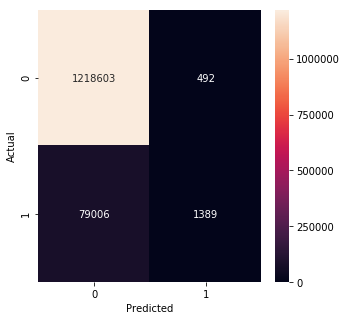

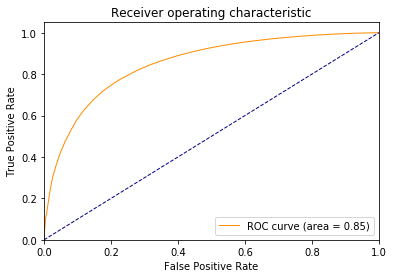

In [13]:
report(best_count_b, 
       X_lemma_train_c, y_lemma_train, 
       X_lemma_hold_c, y_lemma_hold, 
       model_compare, 'BernoulliNB_count')

MultinomialNB(alpha=2.3000000000000003, class_prior=None, fit_prior='True')
              precision    recall  f1-score   support

     Sincere       0.94      1.00      0.97   1219095
   Insincere       0.64      0.03      0.05     80395

    accuracy                           0.94   1299490
   macro avg       0.79      0.51      0.51   1299490
weighted avg       0.92      0.94      0.91   1299490



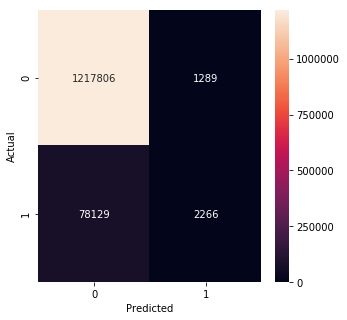

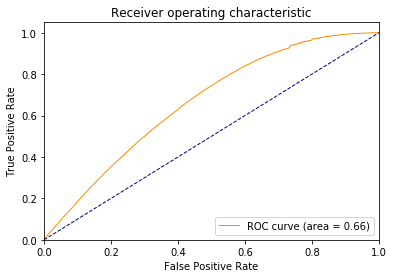

In [14]:
report(best_count_m, 
       X_lemma_train_c, y_lemma_train, 
       X_lemma_hold_c, y_lemma_hold, 
       model_compare, 'MultinomialNB_count')

BernoulliNB(alpha=0.8, binarize=0.0, class_prior=None, fit_prior='True')
              precision    recall  f1-score   support

     Sincere       0.94      1.00      0.97   1219095
   Insincere       0.74      0.02      0.03     80395

    accuracy                           0.94   1299490
   macro avg       0.84      0.51      0.50   1299490
weighted avg       0.93      0.94      0.91   1299490



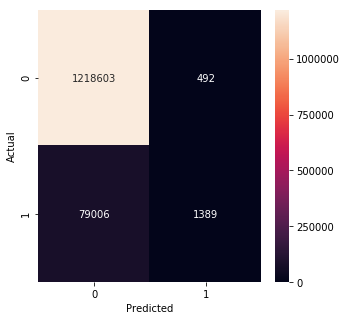

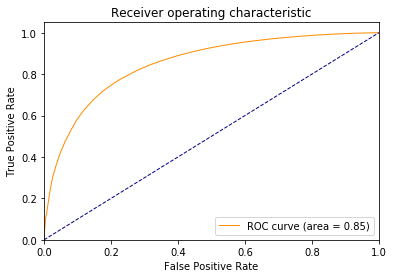

In [15]:
report(best_tfidf_b, 
       X_lemma_train_t, y_lemma_train, 
       X_lemma_hold_t, y_lemma_hold, 
       model_compare, 'BernoulliNB_tfidf')

MultinomialNB(alpha=0.5, class_prior=None, fit_prior='True')
              precision    recall  f1-score   support

     Sincere       0.94      1.00      0.97   1219095
   Insincere       0.67      0.00      0.00     80395

    accuracy                           0.94   1299490
   macro avg       0.80      0.50      0.49   1299490
weighted avg       0.92      0.94      0.91   1299490



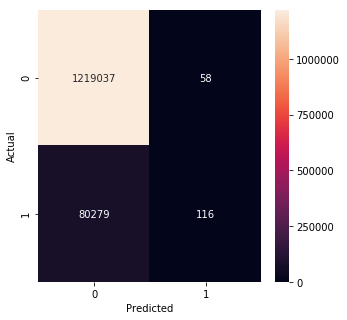

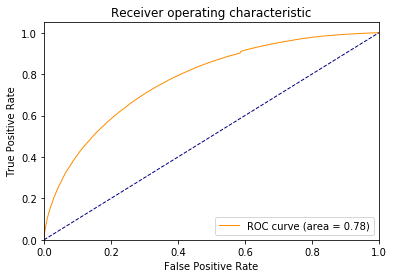

In [16]:
report(best_tfidf_m, 
       X_lemma_train_t, y_lemma_train, 
       X_lemma_hold_t, y_lemma_hold, 
       model_compare, 'MultinomialNB_tfidf')

### Grid Search for Algorithm (Logistic Regression)

In [17]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

param_grid = {'C': [0.001, 0.05, 0.1, 1, 10, 100], 'solver':['newton-cg','lbfgs','sag'],
             } # 'scoring':['f1_precision','f1','f1_recall'], 'penalty' : ['l1','l2'],
best_count = fit(X_lemma_train, y_lemma_train, param_grid, CountVectorizer(), LogisticRegression(max_iter=1000, random_state=42))
best_tfidf = fit(X_lemma_train, y_lemma_train, param_grid, TfidfVectorizer(), LogisticRegression(max_iter=1000,random_state=42))


/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reac

CPU times: user 38.6 s, sys: 898 ms, total: 39.5 s
Wall time: 14.7 s


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.95      0.98      0.97   1219095
   Insincere       0.55      0.28      0.37     80395

    accuracy                           0.94   1299490
   macro avg       0.75      0.63      0.67   1299490
weighted avg       0.93      0.94      0.93   1299490



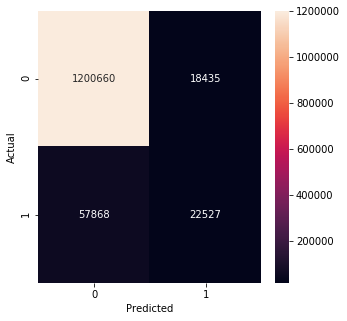

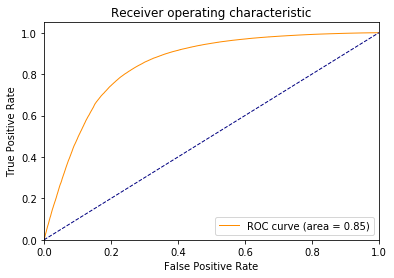

In [ ]:
report(best_count, 
       X_lemma_train_c, y_lemma_train, 
       X_lemma_hold_c, y_lemma_hold, 
       model_compare, 'LogisticRegression_count')

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)
              precision    recall  f1-score   support

     Sincere       0.95      0.98      0.97   1219095
   Insincere       0.50      0.28      0.36     80395

    accuracy                           0.94   1299490
   macro avg       0.73      0.63      0.66   1299490
weighted avg       0.93      0.94      0.93   1299490



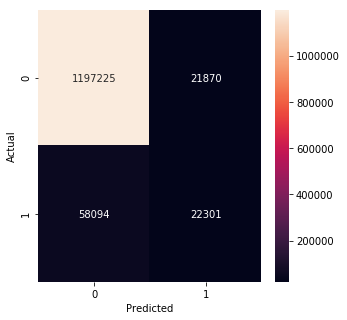

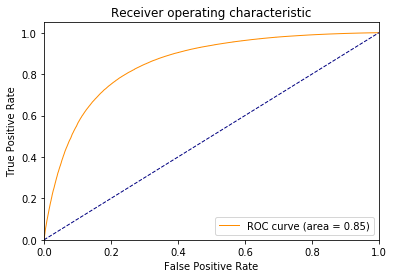

In [ ]:
report(best_tfidf, 
       X_lemma_train_t, y_lemma_train, 
       X_lemma_hold_t, y_lemma_hold, 
       model_compare, 'LogisticRegression_tfidf')

### Grid Search for Algorithm (SVM)

In [ ]:
%%time


from sklearn.svm import SVC, LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

param_grid = {'C': [0.001, 0.05, 0.1, 1, 10, 100],
              'kernel' :['linear', 'rbf', 'sigmoid'],
             } #'scoring':['f1_precision','f1','f1_recall'] 
best_count = fit(X_lemma_train, y_lemma_train, param_grid, CountVectorizer(), SVC(random_state=42, probability=True))
best_tfidf = fit(X_lemma_train, y_lemma_train, param_grid, TfidfVectorizer(), SVC(random_state=42, probability=True))


/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/yang/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 2min 58s, sys: 382 ms, total: 2min 59s
Wall time: 2min 59s


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)
              precision    recall  f1-score   support

     Sincere       0.96      0.98      0.97   1219095
   Insincere       0.49      0.32      0.39     80395

    accuracy                           0.94   1299490
   macro avg       0.72      0.65      0.68   1299490
weighted avg       0.93      0.94      0.93   1299490



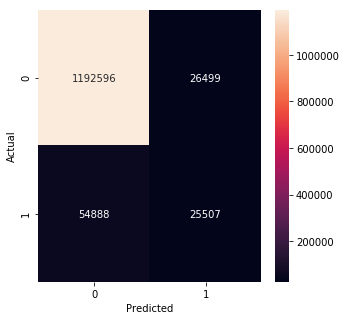

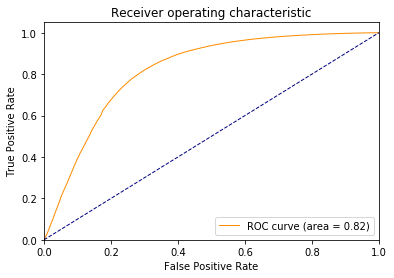

In [ ]:
report(best_count, 
       X_lemma_train_c, y_lemma_train, 
       X_lemma_hold_c, y_lemma_hold, 
       model_compare, 'SVC_count')

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)
              precision    recall  f1-score   support

     Sincere       0.95      1.00      0.97   1219095
   Insincere       0.63      0.13      0.21     80395

    accuracy                           0.94   1299490
   macro avg       0.79      0.56      0.59   1299490
weighted avg       0.93      0.94      0.92   1299490



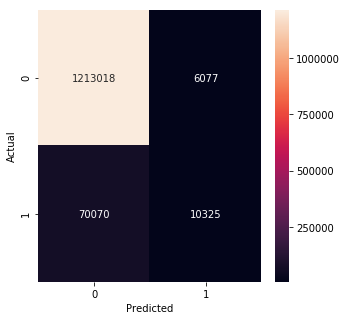

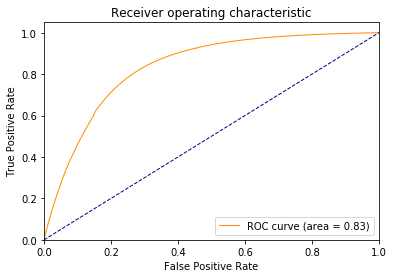

In [ ]:
report(best_tfidf, 
       X_lemma_train_t, y_lemma_train, 
       X_lemma_hold_t, y_lemma_hold, 
       model_compare, 'SVC_tfidf')

### Grid Search for Algorithm (RandomForestClassifier)

In [ ]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

param_grid = {'n_estimators': [10,20, 50, 100, 200], 'criterion':['gini','entropy'],
             } #'scoring':['f1_precision','f1','f1_recall']
best_count_b = fit(X_lemma_train, y_lemma_train, param_grid, CountVectorizer(), RandomForestClassifier(random_state=42))
best_tfidf_b = fit(X_lemma_train, y_lemma_train, param_grid, TfidfVectorizer(), RandomForestClassifier(random_state=42))


CPU times: user 6min 47s, sys: 1.63 s, total: 6min 49s
Wall time: 6min 50s


SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)
              precision    recall  f1-score   support

     Sincere       0.96      0.98      0.97   1219095
   Insincere       0.49      0.32      0.39     80395

    accuracy                           0.94   1299490
   macro avg       0.72      0.65      0.68   1299490
weighted avg       0.93      0.94      0.93   1299490



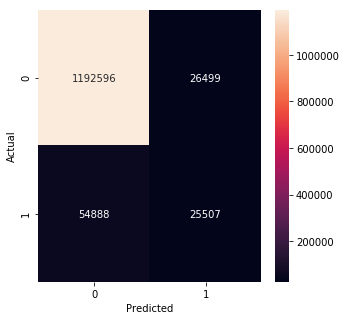

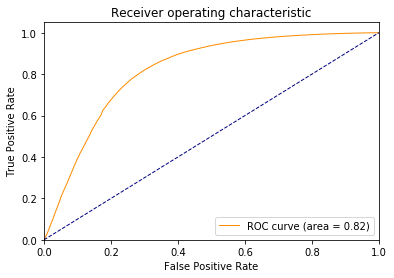

In [ ]:
report(best_count, 
       X_lemma_train_c, y_lemma_train, 
       X_lemma_hold_c, y_lemma_hold, 
       model_compare, 'RandomForestClassifier_count')

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)
              precision    recall  f1-score   support

     Sincere       0.95      1.00      0.97   1219095
   Insincere       0.63      0.13      0.21     80395

    accuracy                           0.94   1299490
   macro avg       0.79      0.56      0.59   1299490
weighted avg       0.93      0.94      0.92   1299490



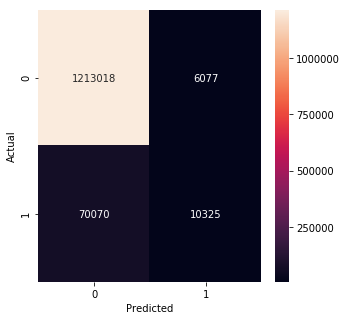

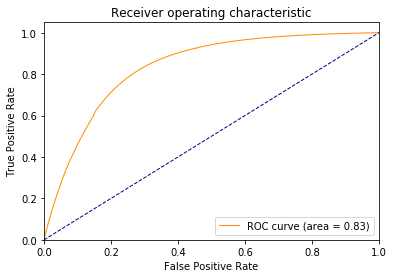

In [ ]:
report(best_tfidf, 
       X_lemma_train_t, y_lemma_train, 
       X_lemma_hold_t, y_lemma_hold, 
       model_compare, 'RandomForestClassifier_tfidf')

### Grid Search for Algorithm (GradientBoostingClassifier)

In [ ]:
%%time

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import numpy as np

param_grid = {'loss' : ['deviance', 'exponential'], 'learning_rate' : np.arange(0.1, 1.2, 0.2),
              'n_estimators':[10, 20, 50, 100, 200], 'subsample' : np.arange(0.4, 1.1, 0.3), 
             } #'scoring':['f1_precision','f1','f1_recall']

best_count = fit(X_lemma_train, y_lemma_train, param_grid, CountVectorizer(), GradientBoostingClassifier(random_state=42))
best_tfidf = fit(X_lemma_train, y_lemma_train, param_grid, TfidfVectorizer(), GradientBoostingClassifier(random_state=42))


In [ ]:
report(best_count, 
       X_lemma_train_c, y_lemma_train, 
       X_lemma_hold_c, y_lemma_hold, 
       model_compare, 'GradientBoostingClassifier_count')

In [ ]:
report(best_tfidf, 
       X_lemma_train_t, y_lemma_train, 
       X_lemma_hold_t, y_lemma_hold, 
       model_compare, 'GradientBoostingClassifier_tfidf')

## CLASSIFICATION REULT COMPARISON

In [ ]:
for key in model_compare:
    print(key)
    print(model_compare[key])